<a href="https://colab.research.google.com/github/Offliners/HTML_2021Fall/blob/main/Final%20Project/HTML2021_Fall_svm_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Directory**

```
data_dir
    ├── data
    │   ├── Test_IDs.csv
    │   ├── ...
    │   ├── status.csv
    ├── statistics
    │   ├── Churn Category_stat.png
    │   ├── ...
    │   ├── miss rate_stat.png
```

# **Display information of GPU**

In [1]:
!nvidia-smi

Wed Jan 12 19:08:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Download Dataset**

In [2]:
!mkdir "./data"
!mkdir "./statistics"
!gdown --id 1X5yz7QLAu4nttnCea4ALf6alae6Clv_o --output "./data/dataset.zip"
!unzip -q "./data/dataset.zip" -d "./data"
!rm "./data/dataset.zip"

Downloading...
From: https://drive.google.com/uc?id=1X5yz7QLAu4nttnCea4ALf6alae6Clv_o
To: /content/data/dataset.zip
100% 660k/660k [00:00<00:00, 37.8MB/s]


# **Import Some Packages**

In [3]:
import time
import numpy as np
import pandas as pd
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report
from imblearn.over_sampling import ADASYN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

# **Set a Random Seed**

In [4]:
# Set a random seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# **CSV Files Combination**

In [5]:
train_path = './data/Train_IDs.csv'  # path to training data
test_path = './data/Test_IDs.csv'    # path to testing data

files = glob('./data/*.csv')
data_csv = []
data_csv.append(train_path)
for csv in files:
    if ('IDs' not in csv) and ('sample' not in csv) and ('population' not in csv) and ('result' not in csv):
        data_csv.append(csv)
  
print(data_csv)
df_list = [pd.read_csv(file) for file in data_csv]

['./data/Train_IDs.csv', './data/location.csv', './data/services.csv', './data/demographics.csv', './data/status.csv', './data/satisfaction.csv']


In [6]:
result_total = df_list[0]
for df in df_list[1:]:
    result_total = pd.merge(result_total, df, how='outer', on='Customer ID')

result_total.to_csv('./data/result_total.csv') # Save combined all result to result_total.csv

In [7]:
# There are 7043 total customer data
print(result_total)

     Customer ID  Count_x  ... Churn Category Satisfaction Score
0     0650-BWOZN      NaN  ...     Competitor                1.0
1     0562-FGDCR      1.0  ...     Competitor                1.0
2     6688-UZPWD      1.0  ...       No Churn                NaN
3     2905-KFQUV      1.0  ...     Competitor                3.0
4     9720-JJJOR      1.0  ...       No Churn                NaN
...          ...      ...  ...            ...                ...
7038  3426-NIYYL      NaN  ...            NaN                NaN
7039  5666-CYCYZ      NaN  ...            NaN                3.0
7040  8263-JQAIK      NaN  ...            NaN                3.0
7041  2754-SDJRD      NaN  ...            NaN                1.0
7042  3251-YMVWZ      NaN  ...            NaN                3.0

[7043 rows x 48 columns]


In [8]:
# Train_IDs has 5634 customer data
result_train = df_list[0]
for df in df_list[1:]:
    result_train = pd.merge(result_train, df, how='left', on='Customer ID')

print(result_train)

     Customer ID  Count_x  ... Churn Category Satisfaction Score
0     0650-BWOZN      NaN  ...     Competitor                1.0
1     0562-FGDCR      1.0  ...     Competitor                1.0
2     6688-UZPWD      1.0  ...       No Churn                NaN
3     2905-KFQUV      1.0  ...     Competitor                3.0
4     9720-JJJOR      1.0  ...       No Churn                NaN
...          ...      ...  ...            ...                ...
5629  1178-PZGAB      NaN  ...            NaN                3.0
5630  4806-KEXQR      1.0  ...            NaN                3.0
5631  8809-RIHDD      NaN  ...       No Churn                4.0
5632  6663-JOCQO      NaN  ...       No Churn                NaN
5633  7010-ZMVBF      1.0  ...       No Churn                4.0

[5634 rows x 48 columns]


In [9]:
# Test_Ids has 1409 customer data
df_test = pd.read_csv(test_path)
result_test = df_test
for df in df_list[1:]:
    result_test = pd.merge(result_test, df, how='left', on='Customer ID')

print(result_test)

     Customer ID  Count_x  ... Churn Category Satisfaction Score
0     9938-EKRGF      1.0  ...            NaN                3.0
1     7379-POKDZ      1.0  ...            NaN                4.0
2     0654-HMSHN      1.0  ...            NaN                5.0
3     2045-BMBTJ      NaN  ...            NaN                NaN
4     0701-TJSEF      1.0  ...            NaN                NaN
...          ...      ...  ...            ...                ...
1404  4587-VVTOX      1.0  ...            NaN                4.0
1405  7716-YTYHG      1.0  ...            NaN                NaN
1406  7649-PHJVR      NaN  ...            NaN                1.0
1407  7855-DIWPO      1.0  ...            NaN                NaN
1408  8197-BFWVU      1.0  ...            NaN                3.0

[1409 rows x 48 columns]


In [10]:
print(result_total.dropna()) # Find customer with full data infomation

     Customer ID  Count_x  ...   Churn Category Satisfaction Score
666   0454-OKRCT      1.0  ...         No Churn                4.0
678   1735-XMJVH      1.0  ...         No Churn                5.0
1799  1245-HARPS      1.0  ...  Dissatisfaction                1.0
2805  8445-DNBAE      1.0  ...       Competitor                1.0
2883  8708-XPXHZ      1.0  ...         No Churn                3.0
3062  9522-ZSINC      1.0  ...         No Churn                4.0
4297  0836-SEYLU      1.0  ...         No Churn                3.0
5146  7274-RTAPZ      1.0  ...         No Churn                5.0

[8 rows x 48 columns]


In [11]:
result_cols = result_total.columns
print(result_cols)

Index(['Customer ID', 'Count_x', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Count_y', 'Quarter',
       'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Offer',
       'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Count', 'Gender', 'Age', 'Under 30', 'Senior Citizen',
       'Married', 'Dependents', 'Number of Dependents', 'Churn Category',
       'Satisfaction Score'],
      dtype='object')


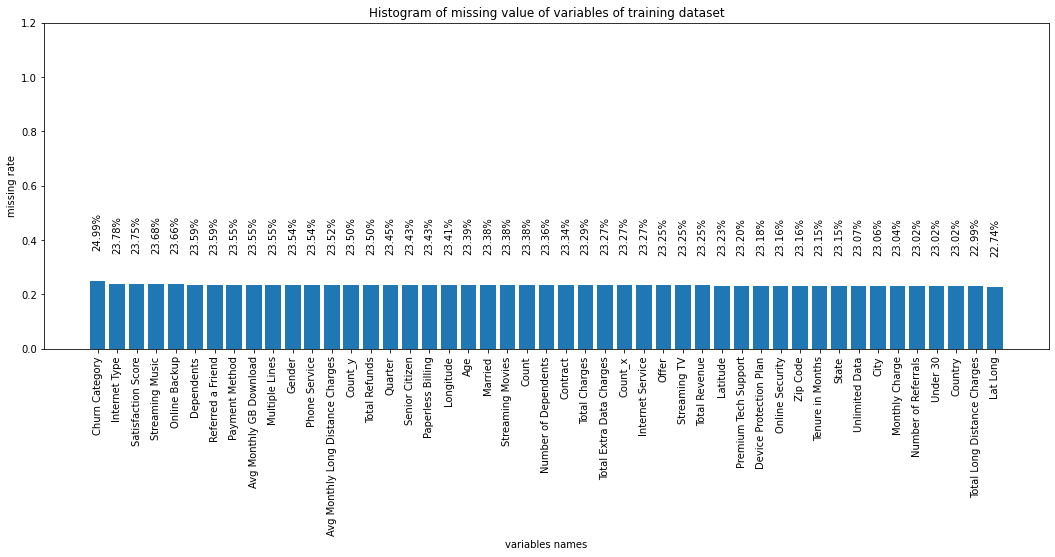

In [12]:
missing = result_train.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_train.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of training dataset')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 1.2])  
plt.savefig(f'./statistics/miss rate_train_stat.png')  
plt.show()
plt.close()

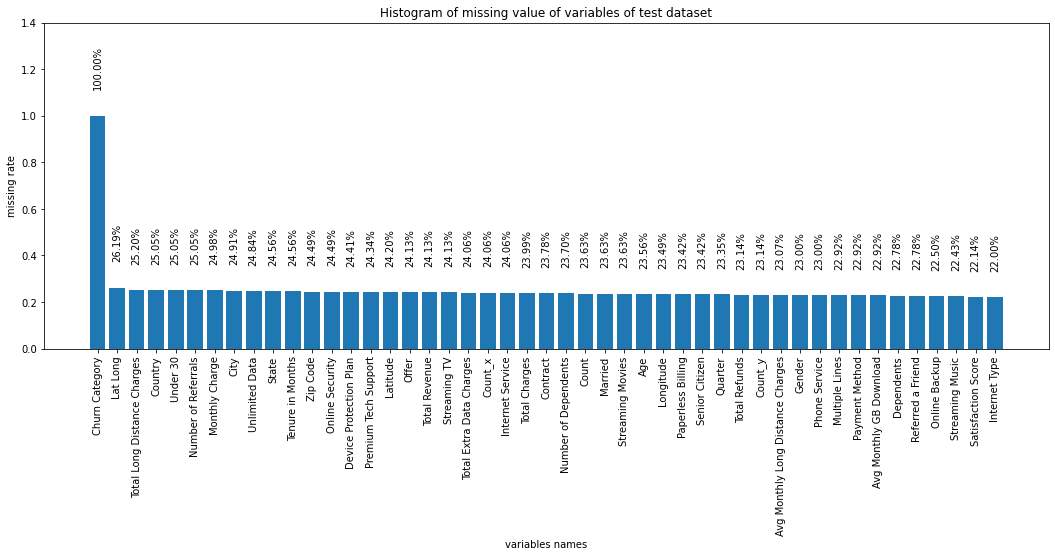

In [13]:
missing = result_test.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_test.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of test dataset')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 1.4])  
plt.savefig(f'./statistics/miss rate_test_stat.png')  
plt.show()
plt.close()

# **Statistics and Data Preprocessing**

In [14]:
result_train_copy = result_train.copy(deep=True)
result_test_copy = result_test.copy(deep=True)
def label_statistics(label):
    freq = result_train.groupby(label).size() 

    names = [name for name, _ in freq.items()]
    counts = [count for _, count in freq.items()]

    fig = plt.figure(figsize=(8, 6))
    x = np.arange(len(names))
    plt.bar(x, counts)
    plt.xticks(x, names, rotation=15)
    plt.title(f'Statistics of {label}')
    plt.savefig(f'./statistics/Statistics of {label}.png')
    print(f'Statistics of {label}.png saved')
    plt.close()

    # Replace NaN with random choice label with the original distribution
    probability = [p / np.sum(counts) for p in counts]
    result_train_copy[label] = result_train_copy[label].apply(lambda x: np.random.choice(names, p=probability) if pd.isnull(x) else x)
    result_test_copy[label] = result_test_copy[label].apply(lambda x: np.random.choice(names, p=probability) if pd.isnull(x) else x)

In [15]:
need_statistics_col = ['Churn Category', 'Satisfaction Score', 
       'Gender', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Country', 'State', 'City', 'Quarter',
       'Referred a Friend', 'Number of Referrals', 'Offer',
       'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method']

# Replace NaN with the most frequent label
for need_col in need_statistics_col:
    label_statistics(need_col)

    # Encode target labels with value
    le = LabelEncoder()
    result_train_copy[need_col] = le.fit_transform(result_train_copy[need_col])
    result_test_copy[need_col] = le.fit_transform(result_test_copy[need_col])

    if need_col == 'Churn Category':
        encoder_map = dict(zip(le.classes_, le.transform(le.classes_)))

Statistics of Churn Category.png saved
Statistics of Satisfaction Score.png saved
Statistics of Gender.png saved
Statistics of Under 30.png saved
Statistics of Senior Citizen.png saved
Statistics of Married.png saved
Statistics of Dependents.png saved
Statistics of Number of Dependents.png saved
Statistics of Country.png saved
Statistics of State.png saved
Statistics of City.png saved
Statistics of Quarter.png saved
Statistics of Referred a Friend.png saved
Statistics of Number of Referrals.png saved
Statistics of Offer.png saved
Statistics of Phone Service.png saved
Statistics of Multiple Lines.png saved
Statistics of Internet Service.png saved
Statistics of Internet Type.png saved
Statistics of Online Security.png saved
Statistics of Online Backup.png saved
Statistics of Device Protection Plan.png saved
Statistics of Premium Tech Support.png saved
Statistics of Streaming TV.png saved
Statistics of Streaming Movies.png saved
Statistics of Streaming Music.png saved
Statistics of Unlimi

In [16]:
need_avg_col = [item for item in result_cols if item not in need_statistics_col]

# Replace NaN with median value or 0
for avg_col in need_avg_col[1:]:
    if avg_col == 'Zip Code' or avg_col == 'Lat Long':
        continue
    elif 'Count' in avg_col:
        result_train_copy[avg_col] = result_train_copy[avg_col].fillna(0)
        result_test_copy[avg_col] = result_test_copy[avg_col].fillna(0)
    else:
        result_train_copy[avg_col] = result_train_copy[avg_col].fillna(result_train_copy[avg_col].median()) 
        result_test_copy[avg_col] = result_test_copy[avg_col].fillna(result_train_copy[avg_col].median())

In [17]:
# Find the correlation of columns
cor_matrix = result_train_copy.corr().abs()
print(cor_matrix['Churn Category'])

Count_x                              0.024353
Country                                   NaN
State                                     NaN
City                                 0.001694
Zip Code                             0.016380
Latitude                             0.050255
Longitude                            0.029237
Count_y                              0.001317
Quarter                                   NaN
Referred a Friend                    0.039161
Number of Referrals                  0.081623
Tenure in Months                     0.124967
Offer                                0.064084
Phone Service                        0.007903
Avg Monthly Long Distance Charges    0.012097
Multiple Lines                       0.025724
Internet Service                     0.093695
Internet Type                        0.041499
Avg Monthly GB Download              0.040774
Online Security                      0.057228
Online Backup                        0.013486
Device Protection Plan            

In [18]:
useless_feature = [index for index, value in cor_matrix['Churn Category'].items() if value < 0.02 or pd.isnull(value)]
useless_feature.append('Lat Long')
print(useless_feature)

['Country', 'State', 'City', 'Zip Code', 'Count_y', 'Quarter', 'Phone Service', 'Avg Monthly Long Distance Charges', 'Online Backup', 'Device Protection Plan', 'Streaming TV', 'Total Refunds', 'Total Extra Data Charges', 'Gender', 'Married', 'Lat Long']


In [19]:
def dropColumns(label):
    global result_train_copy, result_test_copy
    result_train_copy = result_train_copy.drop(label, axis=1)
    result_test_copy = result_test_copy.drop(label, axis=1)

In [20]:
# Throw away the data columns whose correlation to Churn Category is less than 0.55
for item in useless_feature:
    dropColumns(item)

In [21]:
result_train_copy.to_csv('./data/result_after_preprocessing.csv') # Save after preprocessing result to result_after_preprocessing.csv
feature_amount = len(result_train_copy.columns)

print(result_train_copy)
print(result_test_copy)

     Customer ID  Count_x  ...  Churn Category  Satisfaction Score
0     0650-BWOZN      0.0  ...               1                   0
1     0562-FGDCR      1.0  ...               1                   0
2     6688-UZPWD      1.0  ...               3                   2
3     2905-KFQUV      1.0  ...               1                   2
4     9720-JJJOR      1.0  ...               3                   2
...          ...      ...  ...             ...                 ...
5629  1178-PZGAB      0.0  ...               1                   2
5630  4806-KEXQR      1.0  ...               0                   2
5631  8809-RIHDD      0.0  ...               3                   3
5632  6663-JOCQO      0.0  ...               3                   3
5633  7010-ZMVBF      1.0  ...               3                   3

[5634 rows x 32 columns]
     Customer ID  Count_x  ...  Churn Category  Satisfaction Score
0     9938-EKRGF      1.0  ...               3                   2
1     7379-POKDZ      1.0  ...      

# **Balance Data**

In [22]:
y_train = result_train_copy['Churn Category'].values
X_train = result_train_copy.drop('Customer ID', axis=1)
X_train = X_train.drop('Churn Category', axis=1)

In [23]:
print(f"normal data distribution: {Counter(y_train)}")

smo = ADASYN(random_state=seed)
X_train, y_train = smo.fit_resample(X_train, y_train)

print(f"SMOTE data distribution: {Counter(y_train)}")

normal data distribution: Counter({3: 4133, 1: 662, 0: 271, 2: 222, 4: 175, 5: 171})
SMOTE data distribution: Counter({2: 4184, 5: 4165, 4: 4142, 3: 4133, 1: 4110, 0: 4048})


# **SVM Train**

In [24]:
sc = StandardScaler()
ss = StandardScaler().fit(X_train)
X_train_std = ss.transform(X_train)
mms = MinMaxScaler(feature_range=(0, 1)).fit(X_train_std)
X_train_std = mms.transform(X_train_std)

In [25]:
svm = SVC(kernel='rbf', gamma=0.7, C=10, decision_function_shape='ovr')

# SVM with class weight
# svm = SVC(kernel='rbf', gamma=0.7, class_weight={0:10, 1:10, 2:10, 3:1, 4:10, 5:10})

start_time = time.time()
model = svm.fit(X_train_std, y_train)
end_time = time.time()

print(f'Training use {round(end_time - start_time, 3)}s')

Training use 40.624s


In [26]:
y_train_predict = svm.predict(X_train_std)
Ein = np.mean(np.array(y_train_predict) != y_train)
F1in = metrics.f1_score(y_train, y_train_predict, average='macro')  
print(f'Ein = {round(Ein, 5)}')
print(f'F1_in = {round(F1in, 5)}')

Ein = 0.01453
F1_in = 0.98542


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}


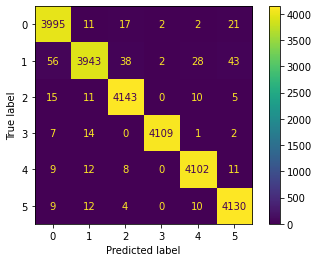

In [27]:
plot_confusion_matrix(model, X_train_std, y_train)
print(encoder_map)

In [28]:
print(classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4048
           1       0.99      0.96      0.97      4110
           2       0.98      0.99      0.99      4184
           3       1.00      0.99      1.00      4133
           4       0.99      0.99      0.99      4142
           5       0.98      0.99      0.99      4165

    accuracy                           0.99     24782
   macro avg       0.99      0.99      0.99     24782
weighted avg       0.99      0.99      0.99     24782



# **SVM Test**

In [29]:
X_test = result_test_copy.drop('Customer ID', axis=1)
X_test = X_test.drop('Churn Category', axis=1)
ss = StandardScaler().fit(X_test)
X_test_std = ss.transform(X_test)
mms = MinMaxScaler(feature_range=(0, 1)).fit(X_test_std)
X_test_std = mms.transform(X_test_std)
y_test = svm.predict(X_test_std)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}


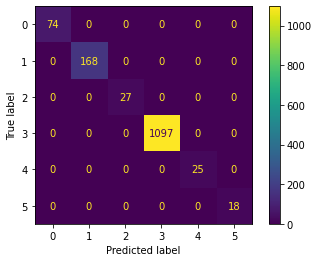

In [30]:
plot_confusion_matrix(model, X_test_std, y_test)
print(encoder_map)

In [31]:
submit_result = './svm_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(y_test[i])])
        f.write(f'{id},{pred}\n')

In [32]:
from google.colab import files

files.download(submit_result)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Deep Neural Network Train**

In [45]:
class IBMDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

In [46]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(feature_amount - 2, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.out = nn.Linear(128, 6)
        self.dp = nn.Dropout(0.1)
        self.act_fn = nn.LeakyReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act_fn(x)
        x = self.bn1(x)
        x = self.dp(x)

        x = self.layer2(x)
        x = self.act_fn(x)
        x = self.bn2(x)
        x = self.dp(x)

        x = self.layer3(x)
        x = self.act_fn(x)
        x = self.bn3(x)
        x = self.dp(x)
        
        x = self.out(x)
        
        return x

# classifier = Classifier()
# summary(classifier, X_train.shape, device="cpu")

In [47]:
VAL_RATIO = 0.2
BATCH_SIZE = 64

sc = StandardScaler()
ss = StandardScaler().fit(X_train)
X_train_std = ss.transform(X_train)

percent = int(X_train_std.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = X_train_std[:percent], y_train[:percent], X_train_std[percent:], y_train[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (19825, 30)
Size of validation set: (4957, 30)


In [48]:
train_set = IBMDataset(train_x, train_y)
val_set = IBMDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
# get device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

# training parameters
num_epoch = 3000             # number of training epoch
learning_rate = 0.001       # learning rate
callback_num = 500

# the path where checkpoint saved
model_path = './best_model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=len(train_loader) * 200, gamma=0.1)

DEVICE: cuda


In [50]:
best_acc = 0.0
count = 0
start_time = time.time()
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward() 
        optimizer.step()
        scheduler.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # Record Training and validation info
            train_acc_list.append(train_acc/len(train_set))
            train_loss_list.append(train_loss/len(train_loader))
            val_acc_list.append(val_acc/len(val_set))
            val_loss_list.append(val_loss/len(val_loader))

            # if the model improves, save a checkpoint at this epoch
            count += 1
            if val_acc > best_acc:
                count = 0
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

    if count > callback_num:
        break

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')

end_time = time.time()

[001/3000] Train Acc: 0.559042 Loss: 1.184268 | Val Acc: 0.110349 loss: 3.348491
saving model with acc 0.110
[002/3000] Train Acc: 0.684338 Loss: 0.863383 | Val Acc: 0.116805 loss: 4.117027
saving model with acc 0.117
[003/3000] Train Acc: 0.745725 Loss: 0.703875 | Val Acc: 0.129514 loss: 4.347677
saving model with acc 0.130
[004/3000] Train Acc: 0.783506 Loss: 0.612651 | Val Acc: 0.133952 loss: 4.326157
saving model with acc 0.134
[005/3000] Train Acc: 0.817907 Loss: 0.526955 | Val Acc: 0.141214 loss: 4.549896
saving model with acc 0.141
[006/3000] Train Acc: 0.836620 Loss: 0.469861 | Val Acc: 0.144846 loss: 4.482773
saving model with acc 0.145
[007/3000] Train Acc: 0.855839 Loss: 0.416672 | Val Acc: 0.150494 loss: 4.394938
saving model with acc 0.150
[008/3000] Train Acc: 0.870416 Loss: 0.376258 | Val Acc: 0.149284 loss: 4.712227
[009/3000] Train Acc: 0.879849 Loss: 0.345859 | Val Acc: 0.157958 loss: 4.395184
saving model with acc 0.158
[010/3000] Train Acc: 0.886204 Loss: 0.320340 |

In [51]:
print(f'Training use {round(end_time - start_time, 3)}s')

Training use 1959.01s


In [52]:
def plot_learning_curve(train_record, valid_record, title=''):
    total_steps = len(train_record)
    x = range(total_steps)
    plt.figure(figsize=(6, 4))
    plt.plot(x, train_record, c='tab:red', label='train')
    plt.plot(x, valid_record, c='tab:cyan', label='valid')
    plt.ylim(0.0, max(valid_record) + 1)
    plt.xlabel('Training epoch')
    plt.ylabel(title)
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

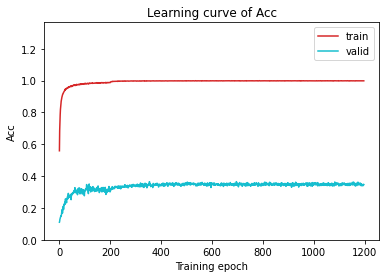

In [53]:
plot_learning_curve(train_acc_list, val_acc_list, 'Acc')

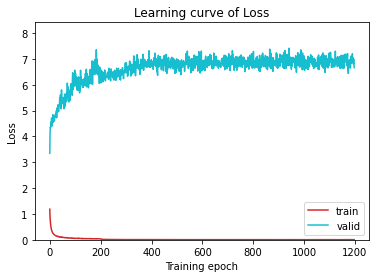

In [54]:
plot_learning_curve(train_loss_list, val_loss_list, 'Loss')

# **Deep Neural Network Test**

In [55]:
sc = StandardScaler()
ss = StandardScaler().fit(X_test)
X_test_std = ss.transform(X_test)

# create testing dataset
test_set = IBMDataset(X_test_std, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [56]:
predict = []
model.eval() # set the model to evaluation mode
for i, data in enumerate(test_loader):
    inputs = data
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

    for y in test_pred.cpu().numpy():
        predict.append(y)

In [57]:
submit_result = './dnn_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(predict[i])])
        f.write(f'{id},{pred}\n')

In [58]:
from google.colab import files

files.download(submit_result)
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **XGBoost Train**

In [59]:
pass